# Introduction to image classification using camera trap images

Next, let's import some of the usual suspects:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch

In [2]:
# Use CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Read in the train and test CSVs first and see what they look like.

In [3]:
train_features = pd.read_csv("train_features.csv", index_col="id")
test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id")

The `features` CSVs contain the image ID, filepath and site ID for each image. 

The `train_labels` CSV is an indicator matrix of the species identified in each of the training images. Some images are labeled as "blank" if no animal was detected.

Let's store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [4]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

## 3. Explore the data

Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label. You can try changing the `random_state` variable to display a new set of images.

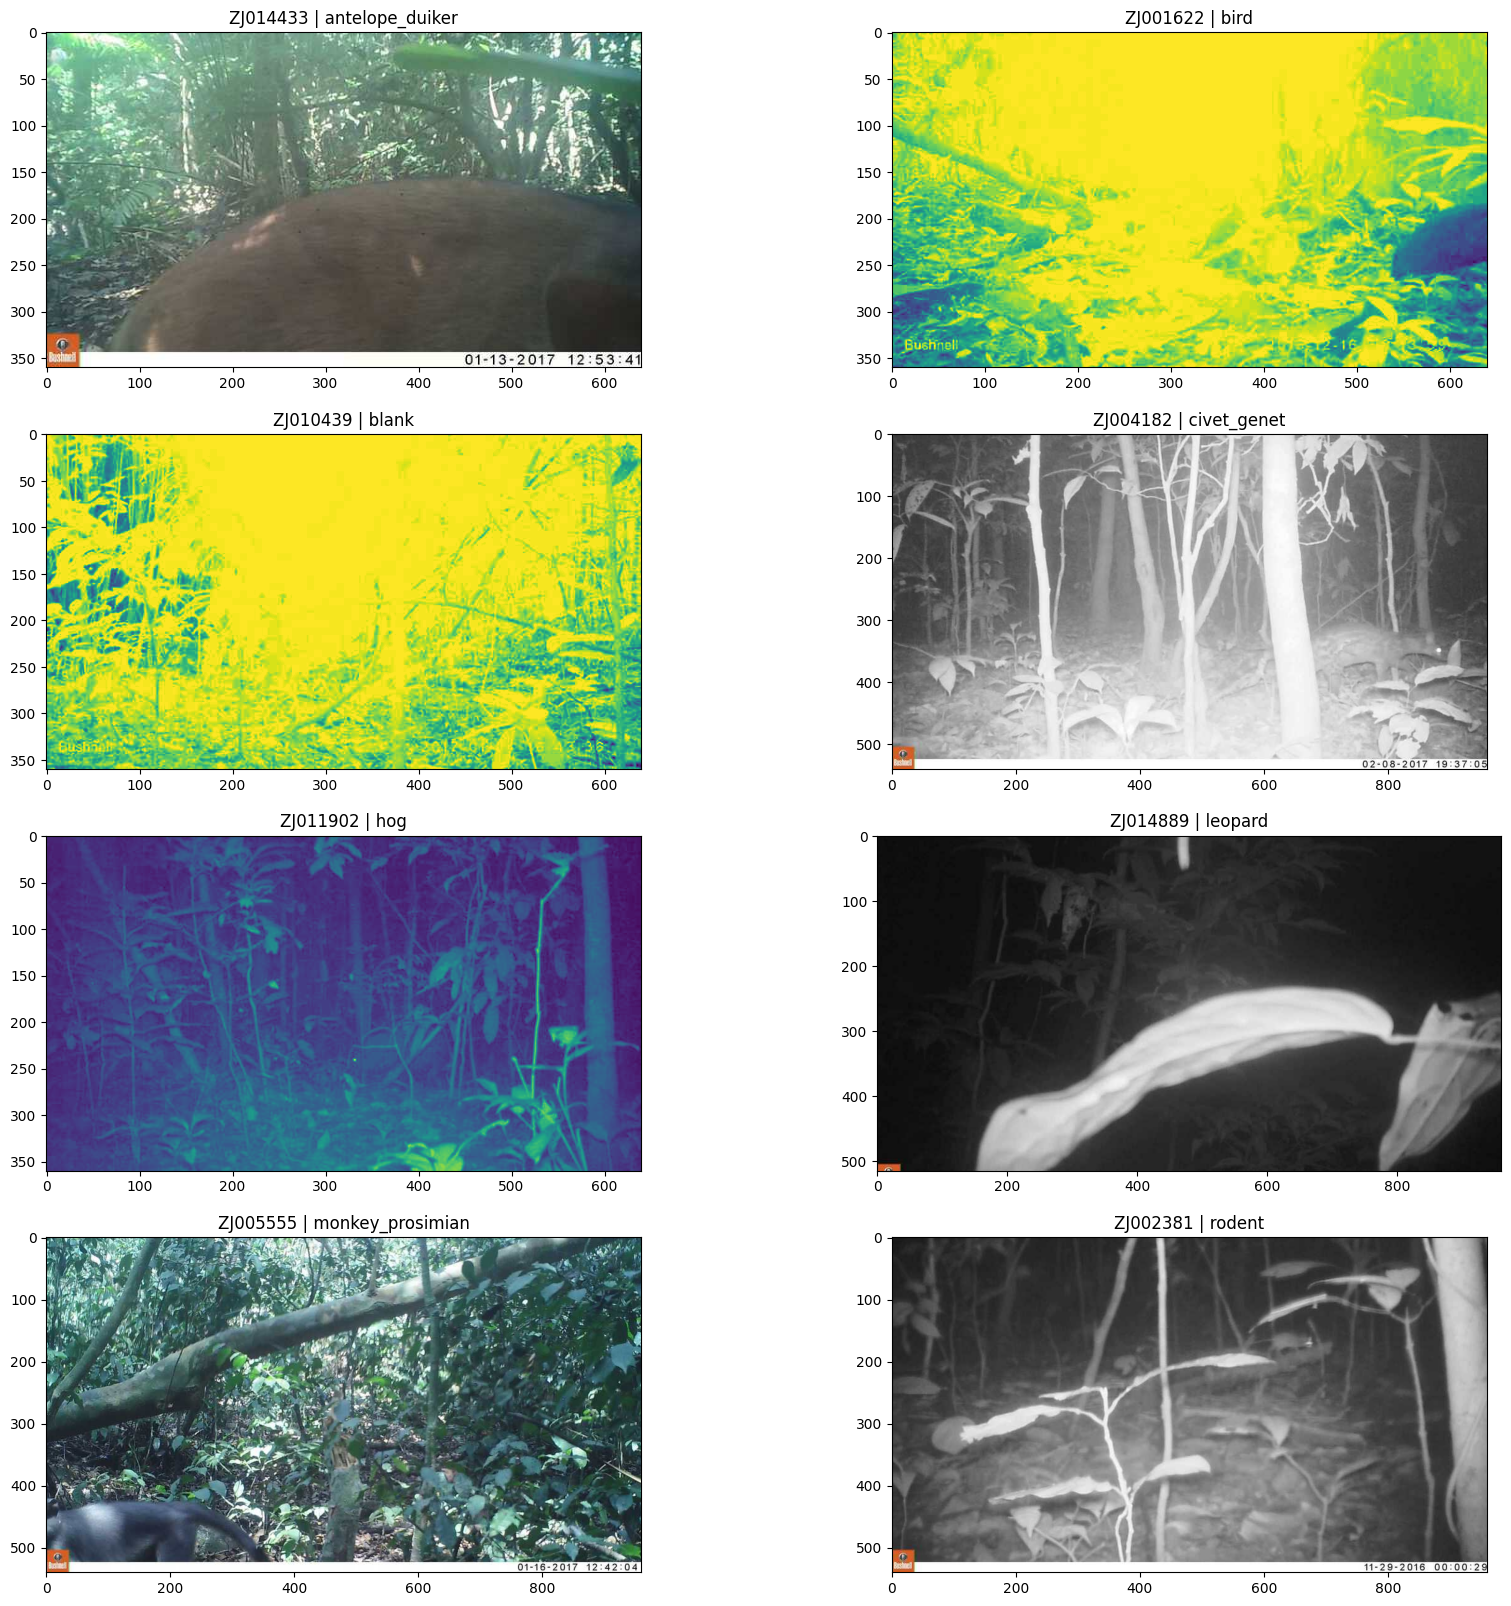

In [5]:
import matplotlib.image as mpimg

random_state = 1

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

## 4. Split into train and evaluation sets
First, we'll need to split the images into train and eval sets. We'll put aside 25% of the data for evaluation and stratify by the target labels to ensure we have similar relative frequencies of each class in the train and eval sets.

For the purposes of this benchmark, we're also going to limit ourselves to a 50% subset of the training data, just so that things run faster. But feel free to adjust `frac` or remove it entirely if you want to run the training on the full set.

In [6]:
from sklearn.model_selection import train_test_split

frac = 1

y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

In [7]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((12366, 1), (12366, 8), (4122, 1), (4122, 8))

Next, let's validate that our split has resulted in roughly similar relative distributions of species across the train and eval sets (because of how we passed `stratify=y` above).

In [8]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,eval
monkey_prosimian,15,15
antelope_duiker,15,15
civet_genet,14,14
leopard,13,13
blank,13,13
rodent,12,12
bird,9,9
hog,5,5


## 5. Build the Model

### The Dataset

First, we'll create an `ImagesDataset` class that will define how we access our data and any transformations we might want to apply. 

This new class will inherit from the PyTorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class, but we'll also need to define our own `__init__`, `__len__` and `__getitem__` **special methods**:
* **`__init__`** will instantiate the dataset object with two dataframes: an `x_train` df containing image IDs and image file paths, and a `y_train` df containing image IDs and labels. This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`.
* **`__getitem__`** will define how we access a sample from the data. This method gets called whenever we use an indexing operation like `dataset[index]`. In this case, whenever accessing a particular image sample (for example, to get the first image we'd do `dataset[0]`) the following will happen:
  * look up the image filepath using the index
  * load the image with [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  * apply some transformations (more on this below)
  * return a dictionary containing the image ID, the image itself as a Tensor, and a label (if it exists)
* **`__len__`** simply returns the size of the dataset, which we do by calling `len` on the input dataframe.

In [9]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None, epoch = 0, eval = False):
        self.data = x_df
        self.label = y_df

        if eval:

            #no transformations but resize
            self.transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),  
                ]
            )

        else:

            if epoch == 1:
                print("Using non-transformed images")
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])

            elif epoch == 2:
                print("Using grayscale images")
                #greyscale images
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.Grayscale(3),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ]) 
            elif epoch == 3:
                #horizontal flip
                print("Using horizontally flipped images")
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=1),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])
            elif epoch == 4:
                #random tilt
                print("Using random tilt images")
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])
            elif epoch == 5:
                #random colour jitter.
                print("Using colour jitter images")
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.ColorJitter(),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])
                #no transformations but resize
            else:
                print("Using random selection of transformations")
                self.transform = transforms.Compose(
                [
                transforms.Resize((224, 224)),
                transforms.RandomApply([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(10),
                    ],0.3),
                transforms.RandomApply([
                    transforms.ColorJitter(),
                    transforms.Grayscale(3)
                    ],0.5), 
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                    ),
                ])
        
                

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

Notice that we are also defining a set of **transformations**, which are defined in the `__init__` and called in the `__getitem__` special methods. These are applied to each image before returning it. Here's what each of those transformations do and why:

* `transforms.Resize((224, 224))` ResNet50 was trained on images of size 224x224 so we resize to the same dimensions here. See [pytorch docs](https://pytorch.org/vision/stable/models.html) and the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).
* `transforms.ToTensor()` converts the image to a tensor. Since we are passing in a PIL Image at this point, PyTorch can recognize it as an RGB image and will automatically convert the input values which are in the range [0, 255] to a range of [0, 1]. See more from the [PyTorch docs](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html).
* `transforms.Normalize(...)` normalizes the image tensors using the mean and standard deviation of ImageNet images. Because this transformation was applied to images when training the ResNet model, we want to do the same here with our images. See more from the [PyTorch docs on pretrained models](https://pytorch.org/vision/stable/models.html).

## 6. Training
Now it's time to start building our model and then training it.

We'll use a pretrained ResNet50 model as our backbone. ResNets are one of the more popular networks for image classification tasks. The pretrained model outputs a 2048-dimension embedding, which we will then connect to two more dense layers, with a ReLU and Dropout step in between. 

These final layers, defined in `model.fc`, are the new "head" of our model, and allow us to transform the image embeddings produced by the pretrained "backbone" into the 8-dimensional output required to learn the species classification task we're tackling here. Prior to redefining it below, `model.fc` would be the final, dense layer connecting the 2048-dimension embedding to a 1000-dimension output (corresponding to the 1000 ImageNet classes that the pretrained model was trained on). We will instead prepare the model for the current task by redefining `model.fc` to produce an 8-dimensional output corresponding to our 8 species classes (including blanks). 

We'll also add a couple more layers in between. The `ReLU` layer introduces non-linearity into the model head, in effect activating important features and suppressing noise. And the `Dropout` layer is a commonly used regularization component that randomly drops some nodes from the previous layer's outputs (10% of nodes in this case) during each training step, mitigating our risk of overfitting.

In [10]:
from torch import nn
import torchvision.models as models


model = models.resnet50(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define our loss function
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

In [11]:
#Define loss function

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
# Send model to GPU
# Send the model to GPU
model = model.to(DEVICE)

In [13]:
from torch.utils.data import DataLoader

num_epochs = 30

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")
    
    train_dataset = ImagesDataset(x_train, y_train, epoch)
    train_dataloader = DataLoader(train_dataset, batch_size=32)

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        
        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the forward step on this batch of images
        outputs = model(batch["image"].to(DEVICE))

        # 3) compute the loss
        loss = criterion(outputs, batch["label"].to(DEVICE))

        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

    print(f"The loss: {round(float(loss),2)} (Not averaged)")

Starting epoch 1
Using non-transformed images


100%|██████████| 387/387 [01:59<00:00,  3.25it/s]


The loss: 1.27 (Not averaged)
Starting epoch 2
Using grayscale images


100%|██████████| 387/387 [01:51<00:00,  3.46it/s]


The loss: 0.79 (Not averaged)
Starting epoch 3
Using horizontally flipped images


100%|██████████| 387/387 [01:46<00:00,  3.63it/s]


The loss: 0.78 (Not averaged)
Starting epoch 4
Using random tilt images


100%|██████████| 387/387 [01:45<00:00,  3.68it/s]


The loss: 0.77 (Not averaged)
Starting epoch 5
Using colour jitter images


100%|██████████| 387/387 [01:45<00:00,  3.65it/s]


The loss: 0.41 (Not averaged)
Starting epoch 6
Using random selection of transformations


100%|██████████| 387/387 [01:48<00:00,  3.58it/s]


The loss: 0.16 (Not averaged)
Starting epoch 7
Using random selection of transformations


100%|██████████| 387/387 [01:45<00:00,  3.67it/s]


The loss: 0.46 (Not averaged)
Starting epoch 8
Using random selection of transformations


100%|██████████| 387/387 [01:45<00:00,  3.67it/s]


The loss: 0.1 (Not averaged)
Starting epoch 9
Using random selection of transformations


100%|██████████| 387/387 [01:46<00:00,  3.64it/s]


The loss: 0.14 (Not averaged)
Starting epoch 10
Using random selection of transformations


100%|██████████| 387/387 [24:06<00:00,  3.74s/it]    


The loss: 0.07 (Not averaged)
Starting epoch 11
Using random selection of transformations


100%|██████████| 387/387 [01:55<00:00,  3.35it/s]


The loss: 0.19 (Not averaged)
Starting epoch 12
Using random selection of transformations


100%|██████████| 387/387 [02:00<00:00,  3.21it/s]


The loss: 0.1 (Not averaged)
Starting epoch 13
Using random selection of transformations


100%|██████████| 387/387 [01:58<00:00,  3.28it/s]


The loss: 0.28 (Not averaged)
Starting epoch 14
Using random selection of transformations


100%|██████████| 387/387 [02:02<00:00,  3.15it/s]


The loss: 0.04 (Not averaged)
Starting epoch 15
Using random selection of transformations


100%|██████████| 387/387 [02:00<00:00,  3.22it/s]


The loss: 0.17 (Not averaged)
Starting epoch 16
Using random selection of transformations


100%|██████████| 387/387 [02:01<00:00,  3.19it/s]


The loss: 0.03 (Not averaged)
Starting epoch 17
Using random selection of transformations


100%|██████████| 387/387 [01:59<00:00,  3.23it/s]


The loss: 0.05 (Not averaged)
Starting epoch 18
Using random selection of transformations


100%|██████████| 387/387 [01:59<00:00,  3.23it/s]


The loss: 0.07 (Not averaged)
Starting epoch 19
Using random selection of transformations


100%|██████████| 387/387 [02:01<00:00,  3.19it/s]


The loss: 0.02 (Not averaged)
Starting epoch 20
Using random selection of transformations


100%|██████████| 387/387 [02:13<00:00,  2.90it/s]


The loss: 0.06 (Not averaged)
Starting epoch 21
Using random selection of transformations


100%|██████████| 387/387 [02:13<00:00,  2.91it/s]


The loss: 0.04 (Not averaged)
Starting epoch 22
Using random selection of transformations


100%|██████████| 387/387 [02:12<00:00,  2.92it/s]


The loss: 0.06 (Not averaged)
Starting epoch 23
Using random selection of transformations


100%|██████████| 387/387 [02:00<00:00,  3.21it/s]


The loss: 0.02 (Not averaged)
Starting epoch 24
Using random selection of transformations


100%|██████████| 387/387 [01:55<00:00,  3.35it/s]


The loss: 0.05 (Not averaged)
Starting epoch 25
Using random selection of transformations


100%|██████████| 387/387 [01:59<00:00,  3.25it/s]


The loss: 0.01 (Not averaged)
Starting epoch 26
Using random selection of transformations


100%|██████████| 387/387 [02:02<00:00,  3.15it/s]


The loss: 0.03 (Not averaged)
Starting epoch 27
Using random selection of transformations


100%|██████████| 387/387 [02:01<00:00,  3.20it/s]


The loss: 0.01 (Not averaged)
Starting epoch 28
Using random selection of transformations


100%|██████████| 387/387 [02:00<00:00,  3.21it/s]


The loss: 0.02 (Not averaged)
Starting epoch 29
Using random selection of transformations


100%|██████████| 387/387 [02:00<00:00,  3.21it/s]


The loss: 0.01 (Not averaged)
Starting epoch 30
Using random selection of transformations


100%|██████████| 387/387 [01:59<00:00,  3.23it/s]

The loss: 0.01 (Not averaged)


Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

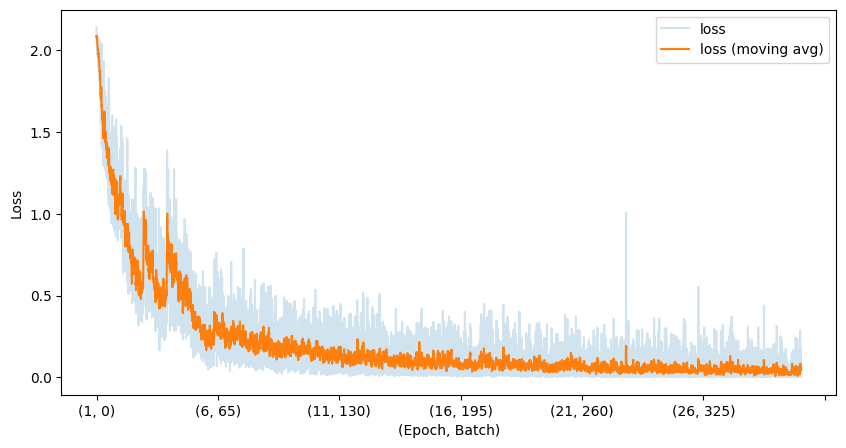

In [14]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

Good news, the loss is going down! This is an encouraging start, especially since we haven't done anything fancy yet.

### Save the model
We have the model loaded in memory already, so we don't really need to save the model, but it's often useful to do this so we can use it again later. 

Here's how:

In [15]:
torch.save(model, "model.pth")

## 7. Evaluation
So far, not so bad. We've shown an improvement in the loss on the training set, but that tells us little about how our model will do on new data. Let's reload our saved model and try generating some predictions on the evaluation split we created earlier.

In [16]:
loaded_model = torch.load("model.pth")

We create the eval dataset and dataloader just like we did earlier with the training dataset and dataloader:

In [17]:
eval_dataset = ImagesDataset(x_eval, y_eval, eval = True)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

### Make predictions
We'll iterate through the eval dataloader in batches, just like we did for training, but this time we aren't going to need to compute gradients or update weights. For each batch, we'll do the following:
1. Run the forward pass to get the model output or logits
2. Apply a softmax function to convert the logits into probability space with range[0,1]. During training, the softmax operation was handled internally by `nn.CrossEntropyLoss`. We aren't computing the loss now because we are just doing evaluation, but we still want the predictions to be in the range[0,1]. 
3. Store the results in a dataframe for further analysis

In [18]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"].to(DEVICE))
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1).to(DEVICE)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.cpu().detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 129/129 [00:27<00:00,  4.64it/s]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ012033,8.349302e-07,1.771948e-09,3.263190e-06,9.999939e-01,4.809370e-07,4.567899e-07,4.370809e-08,9.076558e-07
ZJ003329,3.893318e-05,5.424229e-04,4.480073e-04,5.620246e-03,2.709823e-04,9.757568e-01,1.732168e-02,8.892690e-07
ZJ005628,4.993527e-08,9.999999e-01,6.022011e-08,1.372976e-11,2.297642e-09,4.863865e-10,6.537900e-09,7.206451e-09
ZJ010978,9.995638e-01,1.002855e-06,2.826171e-04,3.536279e-06,4.995488e-06,5.371772e-07,1.331991e-04,1.026002e-05
ZJ008905,3.636128e-10,7.701941e-10,2.182844e-07,9.982528e-01,1.588887e-08,1.533717e-08,5.162295e-10,1.746920e-03
...,...,...,...,...,...,...,...,...
ZJ010135,4.110156e-05,9.983923e-01,1.466561e-03,4.997183e-07,2.773756e-06,2.442390e-05,1.765867e-05,5.472710e-05
ZJ010482,3.918371e-06,4.789027e-06,6.738587e-08,1.767647e-07,3.807529e-09,3.063044e-07,9.999907e-01,4.596855e-10
ZJ007247,9.996502e-01,2.617551e-06,2.039891e-04,5.928469e-06,6.685643e-06,1.564180e-07,7.343019e-05,5.700334e-05
ZJ011994,4.692271e-04,9.842864e-01,1.490653e-02,1.698732e-07,1.528297e-04,8.171631e-05,2.526650e-06,1.007241e-04


### Predicted labels distribution
First let's review the species distribution we saw in the training set.

In [19]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    1869
antelope_duiker     1855
civet_genet         1817
leopard             1690
blank               1660
rodent              1510
bird                1231
hog                  734
dtype: int64

Here's the distribution of our predictions on the eval set. 

In [20]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


monkey_prosimian    657
civet_genet         595
leopard             568
antelope_duiker     555
rodent              546
blank               523
bird                422
hog                 256
dtype: int64

The actual evaluation set is more evenly distributed than our predictions, so we already know there is some room for improvement here.

In [21]:
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    623
antelope_duiker     619
civet_genet         606
leopard             564
blank               553
rodent              503
bird                410
hog                 244
dtype: int64

### Accuracy
Now let's compute how accurate our model is and compare that against some trivial baseline models. First let's get the labels with the highest score for each image.

In [22]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ012033        civet_genet
ZJ003329            leopard
ZJ005628               bird
ZJ010978    antelope_duiker
ZJ008905        civet_genet
dtype: object

In [24]:
eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

0.15114022319262493

In [25]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.8951965065502183

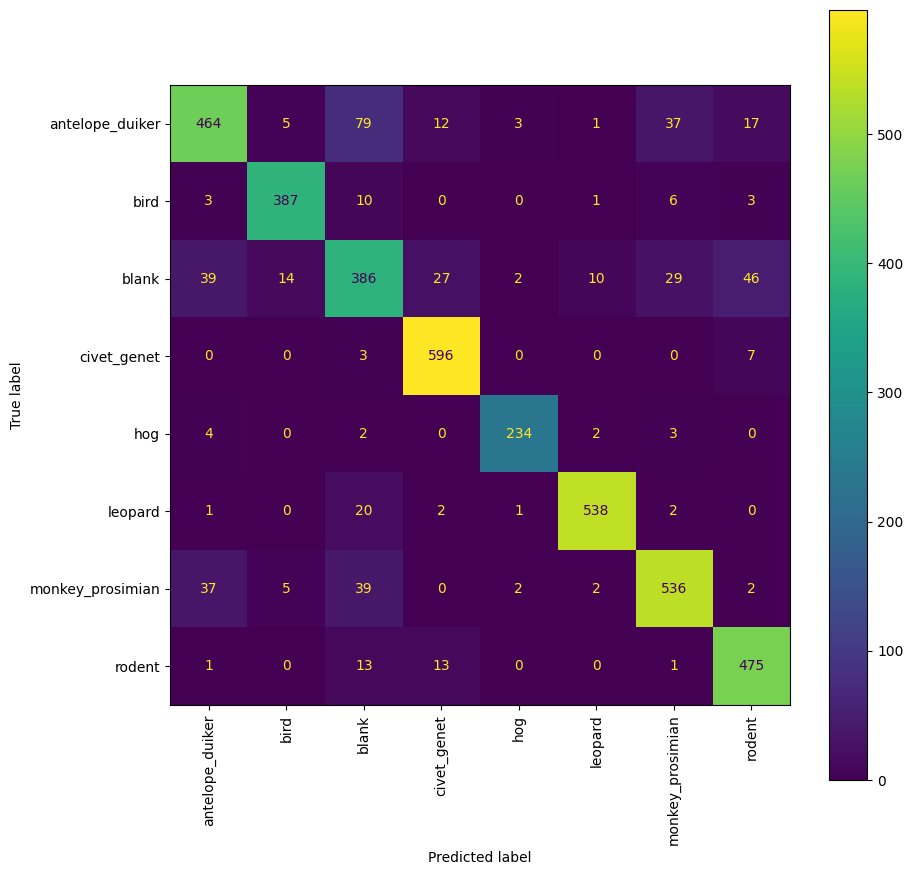

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

That's where you come in! What can you do to improve on this benchmark?

Here are some ideas you might want to try:
* Train on the full training dataset. We've only used 50% of the training data so far.
* Train for more epochs. We've only done 1 so far.
* Try another pretrained model. For example, you may have more success with EfficientNet, or another ResNet model with more layers like ResNet152. See what's available from pytorch [here](https://pytorch.org/vision/stable/models.html). You may also want to review which models are or have been state of the art for image classification tasks, for example on [paperswithcode.com](https://paperswithcode.com/task/image-classification). Keep in mind that different models will require different input and output dimensions, so you'll need to update how you construct `model` above.
* Experiment with different loss functions.
* Experiment with different learning rates or learning rate schedulers.
* Add more layers to the model head (`model.fc`).
* You also may want to consider freezing the weights in the backbone model and only training the head (`model.fc`). If this results in higher accuracy, that suggests the current approach may be overwriting the backbone weights in a problematic way. One approach here would be to train just the model head, and then unfreeze the backbone but train at a lower learning rate.
* Training will be much faster using GPUs, but you will need to make some small tweaks to the code.
* As you become more comfortable iterating through different versions of the model, you may want to try out [PyTorch Lightning](https://www.pytorchlightning.ai/) or [Lightning Flash](https://lightning-flash.readthedocs.io/en/latest/quickstart.html), which build upon PyTorch and eliminate a lot of boilerplate code, in addition to providing a more complete research framework for deep learning problems.

## 8. Create submission

Last but not least, we'll want to participate in the competition and see where we stand on the leaderboard.

To do this we need to create predictions for the **competition test set** (not the eval set we used above). You don't have labels for these.

We'll create predictions in the same way we did for the `eval` set, but this time using the `test_features` we downloaded from the [competition website](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/).

In [ ]:
test_dataset = ImagesDataset(test_features.filepath.to_frame())
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [ ]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        # run the forward step
        logits = model.forward(batch["image"].to(DEVICE))
        # apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1).to(DEVICE)
        # store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

submission_df = pd.concat(preds_collector)
submission_df

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Let's check a couple things on `submission_df` before submitting to the platform. We'll want to make sure our submission's index and column labels match the submission format. (The DrivenData platform will do these data integrity checks as well, but it will be quicker to detect problems this way.)

In [ ]:
submission_format = pd.read_csv("submission_format.csv", index_col="id")

assert all(submission_df.index == submission_format.index)
assert all(submission_df.columns == submission_format.columns)

Looks like we're ready to submit! Save the dataframe out to a CSV file and then upload it via the [Submissions page](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/submissions/) on the competition website.

In [ ]:
submission_df.to_csv("submission_df.csv")

How did we do? We should get a score of ~1.8, though your results may differ slightly due to non-determinism in model training. (For reference, a randomly generated submission yields a score of something like ~2.4.)

![benchmark submission](https://drivendata-public-assets.s3.amazonaws.com/conservision-benchmark-score.jpg)

Now it is up to you to improve on this benchmark!

Head over to the [competition](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/) for data and more background info, or the [competition forum](https://community.drivendata.org/c/conser-vision/87) if you have any questions. Good luck!